In [ ]:
%matplotlib inline


# Speech Command Classification with torchaudio

In this project, we wanna implement a speech command classifier. We have 12 classes, with 40 samples for each class in .mp3 format. First of all, we will load our data as a dataset and then, implement a convolution network to do the task. Finally, we train the model using our dataset and then, report the results.

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [1]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as transforms
import torchaudio
import random
import sys
import os

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load the Data

The samples are packed in a zip file. We upload them to the drive and in the following code, we mount the google drive to our notebook and unzip the desired file to access the files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cp -r /content/drive/MyDrive/12words.zip .

!unzip 12words.zip -d 12words

## Importing the Dataset

We use torchaudio to represent the dataset. Here we use
40sapmles for each class, which is a
dataset of 12 commands spoken by different people. In this dataset, all audio files are about 3 second long and each of them realtes to a simple command (in Persian).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. To load an audio file directly, we use
``torchaudio.load()``, which returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(44.1kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets. This method gets a list of file addresses as an input and when an item is called, it reads the file and returns the waveform, sample rate and labels of that item.




In [68]:
class SpeechCommandDataset(Dataset):
  def __init__(self, data):
    self.path = '/content/12words'
    self.audio = data
    # Match each class name to the corresponding id
    self.id_to_classname = {'1': 'اوراق', '3': 'ارز', '4': 'سکه', '5': 'بانک', '7': 'طلا', '8': 'نفت', '9': 'مشتقات',
                            '11': 'فلزات', '13': 'صندوق سهامی', '15': 'صندوق درآمد ثابت', '17': 'صندوق مختلط', '19': 'صندوق قابل معامله'}

  def __len__(self):
    return len(self.audio)

  def __getitem__(self, indx):
     audio_path = self.audio[indx]
     id = audio_path.split('(')[-1].split(')')[0]
     label = self.id_to_classname[id]

     waveform, sample_rate = torchaudio.load(os.path.join(self.path, id, audio_path))

     return [waveform, sample_rate, label]

Let's write a class that gets the root directory of data and returns the list of files init. The output of this method is the input for the SpeechCommandDataset class.

In [69]:
def getAudioList(_path):
  data = []
  classes = os.listdir(_path)

  for _class in classes:
    file_path = os.path.join(_path, _class)
    data.extend(os.listdir(file_path))

  random.shuffle(data)
  return data

Now it's time to split the data into train, test and validation, and then create a dataset for each of them. In this code, we split the data with the ratio of 80%, 10% and 10% for train, test and validation. Feel free to change these ratios.

In [70]:
total_data = getAudioList('/content/12words')
train_ratio = 0.8
train_size = int(len(total_data) * train_ratio)
test_size = int((len(total_data) - train_size) * 0.5)
valid_size = len(total_data) - train_size - test_size

train_data, test_and_valid = torch.utils.data.random_split(total_data, [train_size, test_size+valid_size], generator=None)
test_data, valid_data = torch.utils.data.random_split(test_and_valid, [test_size, valid_size], generator=None)

train_dataset = SpeechCommandDataset(train_data)
test_dataset = SpeechCommandDataset(test_data)
valid_dataset = SpeechCommandDataset(valid_data)

waveform, sample_rate, label = train_dataset[3]
ipd.Audio(waveform.numpy(), rate=sample_rate)

A data point in the our dataset is a tuple made of a waveform
(the audio signal), the sample rate and the utterance (label).




Shape of waveform: torch.Size([1, 110592])
Sample rate of waveform: 44100


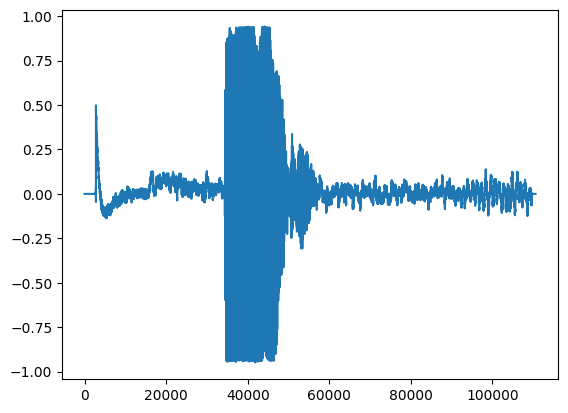

In [71]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

## Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since our dataset uses a
single channel for audio, this is not needed here.




In [72]:
new_sample_rate = 20000
sample_rate = 44100

transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)

Let’s find the list of labels available in the dataset.




In [73]:
labels = sorted(list(set(datapoint[2] for datapoint in train_dataset)))
labels

['ارز',
 'اوراق',
 'بانک',
 'سکه',
 'صندوق درآمد ثابت',
 'صندوق سهامی',
 'صندوق قابل معامله',
 'صندوق مختلط',
 'طلا',
 'فلزات',
 'مشتقات',
 'نفت']

We are encoding each word using its index in the list of labels. So we use tow methods, label_to_index and index_to_label, to match labels with indices.

Pay attention that these indices are different from the ones we had in SpeechCommandDataset. Those we had there we the name of the directories, where the samples were stored. These indices heere are those our model uses to get trained and classify the data.




In [74]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "ارز"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

ارز --> tensor(0) --> ارز


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.


In [75]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

It's time to set the batch size and create the dataloader.

In [76]:
batch_size = 6

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms.




In [77]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=12, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5()
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=12, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [78]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the cross enthropy. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [79]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # cross entropy for a tensor of size (batch x 1 x n_output)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [80]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def valid(model, epoch):
    model.eval()
    correct = 0
    accuracy = 0
    for data, target in valid_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    accuracy += 100. * correct / len(valid_loader.dataset)
    print(f"\nValid Epoch: {epoch}\tAccuracy: {correct}/{len(valid_loader.dataset)} ({100. * correct / len(valid_loader.dataset):.0f}%)\n")
    return accuracy

def test(model):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest: \tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for 20 epochs then reduce the learn rate and train for 20 more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




  0%|          | 0.08333333333333334/60 [00:00<02:49,  2.82s/it] 

Train Epoch: 1 [0/384 (0%)]	Loss: 2.460277


  1%|          | 0.3611111111111112/60 [00:00<02:33,  2.58s/it] 

Train Epoch: 1 [120/384 (31%)]	Loss: 2.284523


  1%|          | 0.6249999999999997/60 [00:01<02:34,  2.60s/it]

Train Epoch: 1 [240/384 (62%)]	Loss: 2.414051


  1%|▏         | 0.8888888888888876/60 [00:02<02:20,  2.38s/it]

Train Epoch: 1 [360/384 (94%)]	Loss: 1.953841


  2%|▏         | 1.0555555555555538/60 [00:02<02:21,  2.40s/it]


Valid Epoch: 1	Accuracy: 4/48 (8%)

Train Epoch: 2 [0/384 (0%)]	Loss: 1.971088


  2%|▏         | 1.3333333333333306/60 [00:03<02:20,  2.40s/it]

Train Epoch: 2 [120/384 (31%)]	Loss: 2.058508


  3%|▎         | 1.652777777777774/60 [00:04<02:23,  2.46s/it] 

Train Epoch: 2 [240/384 (62%)]	Loss: 2.163362


  3%|▎         | 1.902777777777773/60 [00:04<02:20,  2.42s/it] 

Train Epoch: 2 [360/384 (94%)]	Loss: 1.977044


  3%|▎         | 2.0694444444444393/60 [00:05<02:16,  2.35s/it]


Valid Epoch: 2	Accuracy: 12/48 (25%)

Train Epoch: 3 [0/384 (0%)]	Loss: 1.869956


  4%|▍         | 2.347222222222216/60 [00:05<02:14,  2.34s/it] 

Train Epoch: 3 [120/384 (31%)]	Loss: 2.437860


  4%|▍         | 2.611111111111104/60 [00:06<02:24,  2.51s/it] 

Train Epoch: 3 [240/384 (62%)]	Loss: 2.513450


  5%|▍         | 2.9166666666666585/60 [00:07<02:14,  2.36s/it]

Train Epoch: 3 [360/384 (94%)]	Loss: 1.926077


  5%|▌         | 3.0277777777777692/60 [00:07<02:15,  2.38s/it]


Valid Epoch: 3	Accuracy: 10/48 (21%)

Train Epoch: 4 [0/384 (0%)]	Loss: 2.197658


  6%|▌         | 3.3333333333333237/60 [00:08<03:07,  3.31s/it]

Train Epoch: 4 [120/384 (31%)]	Loss: 1.827536


  6%|▌         | 3.5972222222222117/60 [00:09<03:26,  3.66s/it]

Train Epoch: 4 [240/384 (62%)]	Loss: 1.625088


  6%|▋         | 3.8888888888888773/60 [00:10<03:21,  3.59s/it]

Train Epoch: 4 [360/384 (94%)]	Loss: 3.214354


  7%|▋         | 4.055555555555545/60 [00:10<03:14,  3.47s/it]


Valid Epoch: 4	Accuracy: 10/48 (21%)

Train Epoch: 5 [0/384 (0%)]	Loss: 1.645103


  7%|▋         | 4.34722222222222/60 [00:11<02:43,  2.94s/it] 

Train Epoch: 5 [120/384 (31%)]	Loss: 1.641975


  8%|▊         | 4.611111111111116/60 [00:12<02:22,  2.57s/it]

Train Epoch: 5 [240/384 (62%)]	Loss: 1.655354


  8%|▊         | 4.902777777777791/60 [00:13<02:12,  2.40s/it]

Train Epoch: 5 [360/384 (94%)]	Loss: 1.626536


  8%|▊         | 5.069444444444462/60 [00:13<02:07,  2.33s/it]


Valid Epoch: 5	Accuracy: 15/48 (31%)

Train Epoch: 6 [0/384 (0%)]	Loss: 1.257562


  9%|▉         | 5.347222222222248/60 [00:14<02:09,  2.37s/it]

Train Epoch: 6 [120/384 (31%)]	Loss: 1.990717


  9%|▉         | 5.6111111111111445/60 [00:14<02:09,  2.39s/it]

Train Epoch: 6 [240/384 (62%)]	Loss: 1.647256


 10%|▉         | 5.88888888888893/60 [00:15<02:08,  2.37s/it] 

Train Epoch: 6 [360/384 (94%)]	Loss: 2.023164


 10%|█         | 6.0555555555556015/60 [00:15<02:03,  2.30s/it]


Valid Epoch: 6	Accuracy: 10/48 (21%)

Train Epoch: 7 [0/384 (0%)]	Loss: 1.524253


 11%|█         | 6.333333333333387/60 [00:16<02:06,  2.36s/it]

Train Epoch: 7 [120/384 (31%)]	Loss: 1.389606


 11%|█         | 6.611111111111173/60 [00:17<02:09,  2.42s/it]

Train Epoch: 7 [240/384 (62%)]	Loss: 1.599277


 11%|█▏        | 6.875000000000069/60 [00:17<02:04,  2.35s/it]

Train Epoch: 7 [360/384 (94%)]	Loss: 1.369309


 12%|█▏        | 7.041666666666741/60 [00:18<02:05,  2.36s/it] 


Valid Epoch: 7	Accuracy: 11/48 (23%)

Train Epoch: 8 [0/384 (0%)]	Loss: 1.649207


 12%|█▏        | 7.361111111111194/60 [00:19<02:09,  2.47s/it]

Train Epoch: 8 [120/384 (31%)]	Loss: 1.476031


 13%|█▎        | 7.63888888888898/60 [00:19<02:07,  2.44s/it] 

Train Epoch: 8 [240/384 (62%)]	Loss: 1.644155


 13%|█▎        | 7.930555555555655/60 [00:20<02:06,  2.42s/it]

Train Epoch: 8 [360/384 (94%)]	Loss: 1.313427


 13%|█▎        | 8.041666666666769/60 [00:20<02:00,  2.31s/it]


Valid Epoch: 8	Accuracy: 23/48 (48%)

Train Epoch: 9 [0/384 (0%)]	Loss: 1.596064


 14%|█▍        | 8.347222222222333/60 [00:21<02:04,  2.41s/it]

Train Epoch: 9 [120/384 (31%)]	Loss: 1.838832


 14%|█▍        | 8.59722222222234/60 [00:22<02:49,  3.30s/it] 

Train Epoch: 9 [240/384 (62%)]	Loss: 1.775406


 15%|█▍        | 8.888888888889015/60 [00:23<02:57,  3.47s/it]

Train Epoch: 9 [360/384 (94%)]	Loss: 1.880205


 15%|█▌        | 9.055555555555687/60 [00:23<02:50,  3.35s/it]


Valid Epoch: 9	Accuracy: 13/48 (27%)

Train Epoch: 10 [0/384 (0%)]	Loss: 1.710192


 16%|█▌        | 9.347222222222362/60 [00:24<02:54,  3.44s/it]

Train Epoch: 10 [120/384 (31%)]	Loss: 1.428496


 16%|█▌        | 9.611111111111258/60 [00:25<02:38,  3.14s/it]

Train Epoch: 10 [240/384 (62%)]	Loss: 1.458470


 17%|█▋        | 9.916666666666822/60 [00:26<02:16,  2.72s/it]

Train Epoch: 10 [360/384 (94%)]	Loss: 1.593448


 17%|█▋        | 10.055555555555715/60 [00:26<02:08,  2.57s/it]


Valid Epoch: 10	Accuracy: 31/48 (65%)

Train Epoch: 11 [0/384 (0%)]	Loss: 1.197353


 17%|█▋        | 10.34722222222239/60 [00:27<02:09,  2.61s/it] 

Train Epoch: 11 [120/384 (31%)]	Loss: 1.237712


 18%|█▊        | 10.638888888889065/60 [00:28<02:05,  2.55s/it]

Train Epoch: 11 [240/384 (62%)]	Loss: 1.005808


 18%|█▊        | 10.91666666666685/60 [00:29<01:58,  2.42s/it] 

Train Epoch: 11 [360/384 (94%)]	Loss: 0.863456


 18%|█▊        | 11.027777777777965/60 [00:29<01:57,  2.39s/it]


Valid Epoch: 11	Accuracy: 26/48 (54%)

Train Epoch: 12 [0/384 (0%)]	Loss: 1.280707


 19%|█▉        | 11.347222222222419/60 [00:30<01:54,  2.36s/it]

Train Epoch: 12 [120/384 (31%)]	Loss: 1.739186


 19%|█▉        | 11.611111111111315/60 [00:30<02:01,  2.51s/it]

Train Epoch: 12 [240/384 (62%)]	Loss: 1.732055


 20%|█▉        | 11.8888888888891/60 [00:31<02:01,  2.52s/it]  

Train Epoch: 12 [360/384 (94%)]	Loss: 1.491768


 20%|██        | 12.041666666666883/60 [00:31<01:53,  2.38s/it]


Valid Epoch: 12	Accuracy: 20/48 (42%)

Train Epoch: 13 [0/384 (0%)]	Loss: 0.727543


 21%|██        | 12.333333333333558/60 [00:32<01:55,  2.42s/it]

Train Epoch: 13 [120/384 (31%)]	Loss: 1.138543


 21%|██        | 12.638888888889122/60 [00:33<01:52,  2.38s/it]

Train Epoch: 13 [240/384 (62%)]	Loss: 3.070139


 22%|██▏       | 12.916666666666908/60 [00:34<01:51,  2.37s/it]

Train Epoch: 13 [360/384 (94%)]	Loss: 1.016088


 22%|██▏       | 13.083333333333579/60 [00:34<01:48,  2.32s/it]


Valid Epoch: 13	Accuracy: 21/48 (44%)

Train Epoch: 14 [0/384 (0%)]	Loss: 1.358435


 22%|██▏       | 13.333333333333586/60 [00:35<01:54,  2.45s/it]

Train Epoch: 14 [120/384 (31%)]	Loss: 1.069281


 23%|██▎       | 13.625000000000261/60 [00:35<02:20,  3.03s/it]

Train Epoch: 14 [240/384 (62%)]	Loss: 1.090232


 23%|██▎       | 13.875000000000268/60 [00:36<02:40,  3.48s/it]

Train Epoch: 14 [360/384 (94%)]	Loss: 1.155937


 23%|██▎       | 14.04166666666694/60 [00:37<02:41,  3.52s/it] 


Valid Epoch: 14	Accuracy: 34/48 (71%)

Train Epoch: 15 [0/384 (0%)]	Loss: 0.467543


 24%|██▍       | 14.333333333333615/60 [00:38<02:58,  3.91s/it]

Train Epoch: 15 [120/384 (31%)]	Loss: 1.435183


 24%|██▍       | 14.62500000000029/60 [00:39<02:31,  3.33s/it] 

Train Epoch: 15 [240/384 (62%)]	Loss: 1.906158


 25%|██▍       | 14.888888888889186/60 [00:40<01:55,  2.57s/it]

Train Epoch: 15 [360/384 (94%)]	Loss: 0.453871


 25%|██▌       | 15.041666666666968/60 [00:40<01:48,  2.41s/it]


Valid Epoch: 15	Accuracy: 28/48 (58%)

Train Epoch: 16 [0/384 (0%)]	Loss: 0.872875


 26%|██▌       | 15.347222222222532/60 [00:41<01:48,  2.44s/it]

Train Epoch: 16 [120/384 (31%)]	Loss: 1.668276


 26%|██▌       | 15.625000000000318/60 [00:41<01:47,  2.43s/it]

Train Epoch: 16 [240/384 (62%)]	Loss: 1.112164


 26%|██▋       | 15.888888888889214/60 [00:42<01:43,  2.36s/it]

Train Epoch: 16 [360/384 (94%)]	Loss: 0.602137


 27%|██▋       | 16.055555555555884/60 [00:42<01:41,  2.32s/it]


Valid Epoch: 16	Accuracy: 34/48 (71%)

Train Epoch: 17 [0/384 (0%)]	Loss: 0.580777


 27%|██▋       | 16.33333333333367/60 [00:43<01:46,  2.43s/it] 

Train Epoch: 17 [120/384 (31%)]	Loss: 0.910970


 28%|██▊       | 16.611111111111455/60 [00:44<01:45,  2.44s/it]

Train Epoch: 17 [240/384 (62%)]	Loss: 1.054407


 28%|██▊       | 16.93055555555591/60 [00:45<01:45,  2.45s/it]

Train Epoch: 17 [360/384 (94%)]	Loss: 0.832809


 28%|██▊       | 17.041666666667023/60 [00:45<01:40,  2.34s/it]


Valid Epoch: 17	Accuracy: 36/48 (75%)

Train Epoch: 18 [0/384 (0%)]	Loss: 1.351444


 29%|██▉       | 17.347222222222587/60 [00:46<01:42,  2.40s/it]

Train Epoch: 18 [120/384 (31%)]	Loss: 0.393831


 29%|██▉       | 17.611111111111484/60 [00:46<01:44,  2.47s/it]

Train Epoch: 18 [240/384 (62%)]	Loss: 0.898413


 30%|██▉       | 17.916666666667048/60 [00:47<01:42,  2.44s/it]

Train Epoch: 18 [360/384 (94%)]	Loss: 1.123648


 30%|███       | 18.06944444444483/60 [00:47<01:42,  2.43s/it] 


Valid Epoch: 18	Accuracy: 32/48 (67%)

Train Epoch: 19 [0/384 (0%)]	Loss: 0.873343


 31%|███       | 18.361111111111505/60 [00:48<01:43,  2.49s/it]

Train Epoch: 19 [120/384 (31%)]	Loss: 0.821555


 31%|███       | 18.611111111111512/60 [00:49<01:38,  2.39s/it]

Train Epoch: 19 [240/384 (62%)]	Loss: 1.359957


 31%|███▏      | 18.888888888889298/60 [00:50<02:09,  3.16s/it]

Train Epoch: 19 [360/384 (94%)]	Loss: 1.214287


 32%|███▏      | 19.0138888888893/60 [00:50<02:09,  3.17s/it]  


Valid Epoch: 19	Accuracy: 39/48 (81%)

Train Epoch: 20 [0/384 (0%)]	Loss: 0.257945


 32%|███▏      | 19.305555555555976/60 [00:51<02:16,  3.35s/it]

Train Epoch: 20 [120/384 (31%)]	Loss: 0.402211


 33%|███▎      | 19.59722222222265/60 [00:52<02:19,  3.45s/it] 

Train Epoch: 20 [240/384 (62%)]	Loss: 1.021383


 33%|███▎      | 19.888888888889326/60 [00:53<02:26,  3.65s/it]

Train Epoch: 20 [360/384 (94%)]	Loss: 0.398148


 33%|███▎      | 20.069444444444887/60 [00:53<01:50,  2.76s/it]


Valid Epoch: 20	Accuracy: 27/48 (56%)

Train Epoch: 21 [0/384 (0%)]	Loss: 0.305284


 34%|███▍      | 20.361111111111562/60 [00:54<01:43,  2.62s/it]

Train Epoch: 21 [120/384 (31%)]	Loss: 0.652402


 34%|███▍      | 20.62500000000046/60 [00:55<01:43,  2.64s/it]

Train Epoch: 21 [240/384 (62%)]	Loss: 0.157225


 35%|███▍      | 20.888888888889355/60 [00:56<01:41,  2.60s/it]

Train Epoch: 21 [360/384 (94%)]	Loss: 0.544414


 35%|███▌      | 21.069444444444915/60 [00:56<01:43,  2.66s/it]


Valid Epoch: 21	Accuracy: 37/48 (77%)

Train Epoch: 22 [0/384 (0%)]	Loss: 0.340909


 36%|███▌      | 21.36111111111159/60 [00:57<01:46,  2.76s/it] 

Train Epoch: 22 [120/384 (31%)]	Loss: 0.806181


 36%|███▌      | 21.611111111111597/60 [00:57<01:40,  2.63s/it]

Train Epoch: 22 [240/384 (62%)]	Loss: 0.536459


 37%|███▋      | 21.902777777778272/60 [00:58<01:37,  2.57s/it]

Train Epoch: 22 [360/384 (94%)]	Loss: 0.830944


 37%|███▋      | 22.041666666667165/60 [00:59<01:37,  2.56s/it]


Valid Epoch: 22	Accuracy: 37/48 (77%)

Train Epoch: 23 [0/384 (0%)]	Loss: 1.458179


 37%|███▋      | 22.34722222222273/60 [00:59<01:38,  2.63s/it]

Train Epoch: 23 [120/384 (31%)]	Loss: 0.219053


 38%|███▊      | 22.638888888889404/60 [01:00<01:42,  2.74s/it]

Train Epoch: 23 [240/384 (62%)]	Loss: 0.554589


 38%|███▊      | 22.9027777777783/60 [01:01<01:39,  2.67s/it]  

Train Epoch: 23 [360/384 (94%)]	Loss: 0.103049


 38%|███▊      | 23.069444444444972/60 [01:01<01:36,  2.61s/it]


Valid Epoch: 23	Accuracy: 36/48 (75%)

Train Epoch: 24 [0/384 (0%)]	Loss: 0.293293


 39%|███▉      | 23.361111111111647/60 [01:02<01:39,  2.72s/it]

Train Epoch: 24 [120/384 (31%)]	Loss: 0.896972


 39%|███▉      | 23.611111111111654/60 [01:03<01:35,  2.63s/it]

Train Epoch: 24 [240/384 (62%)]	Loss: 0.259540


 40%|███▉      | 23.86111111111166/60 [01:04<02:00,  3.34s/it] 

Train Epoch: 24 [360/384 (94%)]	Loss: 0.541573


 40%|████      | 24.027777777778333/60 [01:04<02:09,  3.61s/it]


Valid Epoch: 24	Accuracy: 39/48 (81%)

Train Epoch: 25 [0/384 (0%)]	Loss: 0.674737


 41%|████      | 24.333333333333897/60 [01:05<02:11,  3.67s/it]

Train Epoch: 25 [120/384 (31%)]	Loss: 0.484967


 41%|████      | 24.611111111111683/60 [01:06<02:21,  4.00s/it]

Train Epoch: 25 [240/384 (62%)]	Loss: 1.177609


 41%|████▏     | 24.88888888888947/60 [01:07<01:55,  3.30s/it]

Train Epoch: 25 [360/384 (94%)]	Loss: 0.283727


 42%|████▏     | 25.06944444444503/60 [01:08<01:33,  2.68s/it]


Valid Epoch: 25	Accuracy: 38/48 (79%)

Train Epoch: 26 [0/384 (0%)]	Loss: 0.258412


 42%|████▏     | 25.361111111111704/60 [01:09<01:33,  2.71s/it]

Train Epoch: 26 [120/384 (31%)]	Loss: 0.776584


 43%|████▎     | 25.61111111111171/60 [01:09<01:36,  2.79s/it] 

Train Epoch: 26 [240/384 (62%)]	Loss: 0.470155


 43%|████▎     | 25.902777777778386/60 [01:10<01:31,  2.68s/it]

Train Epoch: 26 [360/384 (94%)]	Loss: 0.142159


 43%|████▎     | 26.083333333333947/60 [01:11<01:27,  2.59s/it]


Valid Epoch: 26	Accuracy: 38/48 (79%)

Train Epoch: 27 [0/384 (0%)]	Loss: 0.482473


 44%|████▍     | 26.347222222222843/60 [01:11<01:25,  2.55s/it]

Train Epoch: 27 [120/384 (31%)]	Loss: 0.292332


 44%|████▍     | 26.61111111111174/60 [01:12<01:24,  2.52s/it]

Train Epoch: 27 [240/384 (62%)]	Loss: 0.258617


 45%|████▍     | 26.930555555556193/60 [01:13<01:21,  2.46s/it]

Train Epoch: 27 [360/384 (94%)]	Loss: 0.318484


 45%|████▌     | 27.041666666667307/60 [01:13<01:18,  2.38s/it]


Valid Epoch: 27	Accuracy: 40/48 (83%)

Train Epoch: 28 [0/384 (0%)]	Loss: 0.180855


 46%|████▌     | 27.333333333333982/60 [01:14<01:21,  2.49s/it]

Train Epoch: 28 [120/384 (31%)]	Loss: 0.400594


 46%|████▌     | 27.59722222222288/60 [01:14<01:24,  2.62s/it]

Train Epoch: 28 [240/384 (62%)]	Loss: 0.453640


 47%|████▋     | 27.916666666667332/60 [01:15<01:16,  2.37s/it]

Train Epoch: 28 [360/384 (94%)]	Loss: 0.178249


 47%|████▋     | 28.027777777778446/60 [01:15<01:16,  2.40s/it]


Valid Epoch: 28	Accuracy: 39/48 (81%)

Train Epoch: 29 [0/384 (0%)]	Loss: 0.293472


 47%|████▋     | 28.33333333333401/60 [01:16<01:17,  2.44s/it] 

Train Epoch: 29 [120/384 (31%)]	Loss: 0.393497


 48%|████▊     | 28.638888888889575/60 [01:17<01:17,  2.48s/it]

Train Epoch: 29 [240/384 (62%)]	Loss: 0.851781


 48%|████▊     | 28.90277777777847/60 [01:18<01:35,  3.08s/it] 

Train Epoch: 29 [360/384 (94%)]	Loss: 0.336605


 48%|████▊     | 29.027777777778475/60 [01:18<01:41,  3.29s/it]


Valid Epoch: 29	Accuracy: 41/48 (85%)

Train Epoch: 30 [0/384 (0%)]	Loss: 0.197110


 49%|████▉     | 29.31944444444515/60 [01:19<01:45,  3.43s/it] 

Train Epoch: 30 [120/384 (31%)]	Loss: 0.437747


 49%|████▉     | 29.611111111111825/60 [01:20<01:46,  3.52s/it]

Train Epoch: 30 [240/384 (62%)]	Loss: 0.560364


 50%|████▉     | 29.9027777777785/60 [01:21<01:44,  3.48s/it]  

Train Epoch: 30 [360/384 (94%)]	Loss: 0.302543


 50%|█████     | 30.055555555556282/60 [01:22<01:19,  2.65s/it]


Valid Epoch: 30	Accuracy: 42/48 (88%)

Train Epoch: 31 [0/384 (0%)]	Loss: 0.263409


 51%|█████     | 30.347222222222957/60 [01:22<01:14,  2.51s/it]

Train Epoch: 31 [120/384 (31%)]	Loss: 0.450785


 51%|█████     | 30.611111111111853/60 [01:23<01:09,  2.37s/it]

Train Epoch: 31 [240/384 (62%)]	Loss: 0.287777


 51%|█████▏    | 30.88888888888964/60 [01:24<01:12,  2.49s/it]

Train Epoch: 31 [360/384 (94%)]	Loss: 0.296127


 52%|█████▏    | 31.0694444444452/60 [01:24<01:10,  2.43s/it] 


Valid Epoch: 31	Accuracy: 40/48 (83%)

Train Epoch: 32 [0/384 (0%)]	Loss: 0.236215


 52%|█████▏    | 31.361111111111875/60 [01:25<01:13,  2.58s/it]

Train Epoch: 32 [120/384 (31%)]	Loss: 0.756223


 53%|█████▎    | 31.63888888888966/60 [01:26<01:09,  2.43s/it] 

Train Epoch: 32 [240/384 (62%)]	Loss: 0.100475


 53%|█████▎    | 31.916666666667446/60 [01:26<01:09,  2.46s/it]

Train Epoch: 32 [360/384 (94%)]	Loss: 0.612386


 53%|█████▎    | 32.083333333334096/60 [01:27<01:04,  2.30s/it]


Valid Epoch: 32	Accuracy: 40/48 (83%)

Train Epoch: 33 [0/384 (0%)]	Loss: 0.219993


 54%|█████▍    | 32.36111111111181/60 [01:27<01:09,  2.50s/it]

Train Epoch: 33 [120/384 (31%)]	Loss: 0.586913


 54%|█████▍    | 32.62500000000064/60 [01:28<01:11,  2.62s/it]

Train Epoch: 33 [240/384 (62%)]	Loss: 0.297479


 55%|█████▍    | 32.91666666666724/60 [01:29<01:04,  2.40s/it]

Train Epoch: 33 [360/384 (94%)]	Loss: 0.680772


 55%|█████▌    | 33.027777777778326/60 [01:29<01:04,  2.38s/it]


Valid Epoch: 33	Accuracy: 39/48 (81%)

Train Epoch: 34 [0/384 (0%)]	Loss: 0.236348


 56%|█████▌    | 33.33333333333381/60 [01:30<01:03,  2.39s/it]

Train Epoch: 34 [120/384 (31%)]	Loss: 0.094951


 56%|█████▌    | 33.611111111111526/60 [01:30<01:07,  2.57s/it]

Train Epoch: 34 [240/384 (62%)]	Loss: 0.291841


 57%|█████▋    | 33.91666666666701/60 [01:31<01:04,  2.48s/it] 

Train Epoch: 34 [360/384 (94%)]	Loss: 0.314159


 57%|█████▋    | 34.041666666666984/60 [01:32<01:18,  3.02s/it]


Valid Epoch: 34	Accuracy: 41/48 (85%)

Train Epoch: 35 [0/384 (0%)]	Loss: 0.247991


 57%|█████▋    | 34.333333333333584/60 [01:33<01:27,  3.41s/it]

Train Epoch: 35 [120/384 (31%)]	Loss: 0.775655


 58%|█████▊    | 34.625000000000185/60 [01:34<01:28,  3.50s/it]

Train Epoch: 35 [240/384 (62%)]	Loss: 0.122393


 58%|█████▊    | 34.9027777777779/60 [01:35<01:30,  3.60s/it] 

Train Epoch: 35 [360/384 (94%)]	Loss: 0.262227


 58%|█████▊    | 35.05555555555564/60 [01:35<01:28,  3.53s/it] 


Valid Epoch: 35	Accuracy: 40/48 (83%)

Train Epoch: 36 [0/384 (0%)]	Loss: 0.284906


 59%|█████▉    | 35.34722222222224/60 [01:36<01:03,  2.58s/it] 

Train Epoch: 36 [120/384 (31%)]	Loss: 0.176232


 59%|█████▉    | 35.62499999999996/60 [01:37<01:01,  2.50s/it]

Train Epoch: 36 [240/384 (62%)]	Loss: 0.111983


 60%|█████▉    | 35.91666666666656/60 [01:37<01:01,  2.55s/it]

Train Epoch: 36 [360/384 (94%)]	Loss: 0.201226


 60%|██████    | 36.055555555555415/60 [01:38<00:58,  2.44s/it]


Valid Epoch: 36	Accuracy: 40/48 (83%)

Train Epoch: 37 [0/384 (0%)]	Loss: 0.613572


 61%|██████    | 36.33333333333313/60 [01:38<00:58,  2.49s/it]

Train Epoch: 37 [120/384 (31%)]	Loss: 0.406832


 61%|██████    | 36.59722222222196/60 [01:39<01:00,  2.58s/it]

Train Epoch: 37 [240/384 (62%)]	Loss: 0.305358


 62%|██████▏   | 36.91666666666633/60 [01:40<00:56,  2.46s/it]

Train Epoch: 37 [360/384 (94%)]	Loss: 0.303743


 62%|██████▏   | 37.0416666666663/60 [01:40<00:56,  2.46s/it]  


Valid Epoch: 37	Accuracy: 39/48 (81%)

Train Epoch: 38 [0/384 (0%)]	Loss: 0.259326


 62%|██████▏   | 37.361111111110674/60 [01:41<00:54,  2.41s/it]

Train Epoch: 38 [120/384 (31%)]	Loss: 0.389454


 63%|██████▎   | 37.61111111111062/60 [01:42<00:56,  2.54s/it]

Train Epoch: 38 [240/384 (62%)]	Loss: 0.340473


 63%|██████▎   | 37.90277777777722/60 [01:42<00:55,  2.53s/it]

Train Epoch: 38 [360/384 (94%)]	Loss: 0.513203


 63%|██████▎   | 38.069444444443846/60 [01:43<00:53,  2.42s/it]


Valid Epoch: 38	Accuracy: 40/48 (83%)

Train Epoch: 39 [0/384 (0%)]	Loss: 0.146567


 64%|██████▍   | 38.333333333332675/60 [01:43<00:51,  2.38s/it]

Train Epoch: 39 [120/384 (31%)]	Loss: 0.247641


 64%|██████▍   | 38.63888888888816/60 [01:44<00:52,  2.47s/it]

Train Epoch: 39 [240/384 (62%)]	Loss: 0.335665


 65%|██████▍   | 38.90277777777699/60 [01:45<00:53,  2.51s/it]

Train Epoch: 39 [360/384 (94%)]	Loss: 0.241278


 65%|██████▌   | 39.04166666666585/60 [01:45<00:52,  2.49s/it]


Valid Epoch: 39	Accuracy: 40/48 (83%)

Train Epoch: 40 [0/384 (0%)]	Loss: 0.240030


 66%|██████▌   | 39.33333333333245/60 [01:46<01:15,  3.64s/it]

Train Epoch: 40 [120/384 (31%)]	Loss: 0.253669


 66%|██████▌   | 39.61111111111016/60 [01:47<01:10,  3.46s/it] 

Train Epoch: 40 [240/384 (62%)]	Loss: 0.435230


 67%|██████▋   | 39.90277777777676/60 [01:48<01:07,  3.36s/it] 

Train Epoch: 40 [360/384 (94%)]	Loss: 0.355284


 67%|██████▋   | 40.027777777776734/60 [01:49<01:06,  3.32s/it]


Valid Epoch: 40	Accuracy: 41/48 (85%)

Train Epoch: 41 [0/384 (0%)]	Loss: 0.190272


 67%|██████▋   | 40.33333333333222/60 [01:50<00:55,  2.82s/it]

Train Epoch: 41 [120/384 (31%)]	Loss: 0.500538


 68%|██████▊   | 40.62499999999882/60 [01:50<00:49,  2.55s/it]

Train Epoch: 41 [240/384 (62%)]	Loss: 0.193775


 68%|██████▊   | 40.902777777776535/60 [01:51<00:46,  2.41s/it]

Train Epoch: 41 [360/384 (94%)]	Loss: 0.239270


 68%|██████▊   | 41.05555555555428/60 [01:51<00:45,  2.41s/it] 


Valid Epoch: 41	Accuracy: 39/48 (81%)

Train Epoch: 42 [0/384 (0%)]	Loss: 0.477865


 69%|██████▉   | 41.37499999999865/60 [01:52<00:44,  2.39s/it]

Train Epoch: 42 [120/384 (31%)]	Loss: 0.516599


 69%|██████▉   | 41.63888888888748/60 [01:53<00:46,  2.52s/it]

Train Epoch: 42 [240/384 (62%)]	Loss: 0.234436


 70%|██████▉   | 41.88888888888742/60 [01:53<00:45,  2.50s/it] 

Train Epoch: 42 [360/384 (94%)]	Loss: 0.146905


 70%|███████   | 42.05555555555405/60 [01:54<00:42,  2.39s/it]


Valid Epoch: 42	Accuracy: 40/48 (83%)

Train Epoch: 43 [0/384 (0%)]	Loss: 0.672580


 71%|███████   | 42.36111111110954/60 [01:55<00:42,  2.40s/it] 

Train Epoch: 43 [120/384 (31%)]	Loss: 0.039216


 71%|███████   | 42.624999999998366/60 [01:55<00:43,  2.50s/it]

Train Epoch: 43 [240/384 (62%)]	Loss: 0.086643


 72%|███████▏  | 42.916666666664966/60 [01:56<00:40,  2.39s/it]

Train Epoch: 43 [360/384 (94%)]	Loss: 0.251078


 72%|███████▏  | 43.083333333331595/60 [01:56<00:38,  2.26s/it]


Valid Epoch: 43	Accuracy: 40/48 (83%)

Train Epoch: 44 [0/384 (0%)]	Loss: 0.172326


 72%|███████▏  | 43.347222222220424/60 [01:57<00:39,  2.39s/it]

Train Epoch: 44 [120/384 (31%)]	Loss: 0.212668


 73%|███████▎  | 43.61111111110925/60 [01:58<00:40,  2.47s/it] 

Train Epoch: 44 [240/384 (62%)]	Loss: 1.304374


 73%|███████▎  | 43.90277777777585/60 [01:58<00:37,  2.34s/it]

Train Epoch: 44 [360/384 (94%)]	Loss: 0.494365


 73%|███████▎  | 44.06944444444248/60 [01:59<00:35,  2.23s/it]


Valid Epoch: 44	Accuracy: 39/48 (81%)

Train Epoch: 45 [0/384 (0%)]	Loss: 0.242882


 74%|███████▍  | 44.347222222220196/60 [01:59<00:40,  2.57s/it]

Train Epoch: 45 [120/384 (31%)]	Loss: 0.354079


 74%|███████▍  | 44.59722222222014/60 [02:00<00:53,  3.45s/it]

Train Epoch: 45 [240/384 (62%)]	Loss: 0.273663


 75%|███████▍  | 44.88888888888674/60 [02:01<00:51,  3.43s/it]

Train Epoch: 45 [360/384 (94%)]	Loss: 0.109305


 75%|███████▌  | 45.01388888888671/60 [02:02<00:48,  3.26s/it] 


Valid Epoch: 45	Accuracy: 41/48 (85%)

Train Epoch: 46 [0/384 (0%)]	Loss: 0.083957


 76%|███████▌  | 45.34722222221997/60 [02:03<00:52,  3.56s/it]

Train Epoch: 46 [120/384 (31%)]	Loss: 0.919455


 76%|███████▌  | 45.6111111111088/60 [02:04<00:42,  2.92s/it] 

Train Epoch: 46 [240/384 (62%)]	Loss: 0.123285


 76%|███████▋  | 45.88888888888651/60 [02:04<00:35,  2.52s/it] 

Train Epoch: 46 [360/384 (94%)]	Loss: 0.448276


 77%|███████▋  | 46.05555555555314/60 [02:05<00:33,  2.38s/it]


Valid Epoch: 46	Accuracy: 39/48 (81%)

Train Epoch: 47 [0/384 (0%)]	Loss: 0.256736


 77%|███████▋  | 46.34722222221974/60 [02:05<00:33,  2.47s/it] 

Train Epoch: 47 [120/384 (31%)]	Loss: 0.417256


 78%|███████▊  | 46.63888888888634/60 [02:06<00:33,  2.51s/it] 

Train Epoch: 47 [240/384 (62%)]	Loss: 0.303722


 78%|███████▊  | 46.91666666666406/60 [02:07<00:33,  2.55s/it]

Train Epoch: 47 [360/384 (94%)]	Loss: 0.694792


 78%|███████▊  | 47.055555555552914/60 [02:07<00:32,  2.52s/it]


Valid Epoch: 47	Accuracy: 40/48 (83%)

Train Epoch: 48 [0/384 (0%)]	Loss: 0.437853


 79%|███████▉  | 47.31944444444174/60 [02:08<00:32,  2.54s/it] 

Train Epoch: 48 [120/384 (31%)]	Loss: 0.191707


 79%|███████▉  | 47.652777777775/60 [02:09<00:29,  2.43s/it]  

Train Epoch: 48 [240/384 (62%)]	Loss: 0.337643


 80%|███████▉  | 47.90277777777494/60 [02:09<00:29,  2.45s/it] 

Train Epoch: 48 [360/384 (94%)]	Loss: 0.247383


 80%|████████  | 48.06944444444157/60 [02:10<00:27,  2.34s/it]


Valid Epoch: 48	Accuracy: 40/48 (83%)

Train Epoch: 49 [0/384 (0%)]	Loss: 0.259615


 81%|████████  | 48.34722222221929/60 [02:10<00:29,  2.54s/it]

Train Epoch: 49 [120/384 (31%)]	Loss: 0.439933


 81%|████████  | 48.65277777777477/60 [02:11<00:27,  2.44s/it] 

Train Epoch: 49 [240/384 (62%)]	Loss: 0.372416


 82%|████████▏ | 48.902777777774716/60 [02:12<00:25,  2.34s/it]

Train Epoch: 49 [360/384 (94%)]	Loss: 0.227316


 82%|████████▏ | 49.069444444441345/60 [02:12<00:25,  2.34s/it]


Valid Epoch: 49	Accuracy: 41/48 (85%)

Train Epoch: 50 [0/384 (0%)]	Loss: 0.388607


 82%|████████▏ | 49.34722222221906/60 [02:13<00:24,  2.34s/it]

Train Epoch: 50 [120/384 (31%)]	Loss: 0.396415


 83%|████████▎ | 49.61111111110789/60 [02:13<00:28,  2.71s/it]

Train Epoch: 50 [240/384 (62%)]	Loss: 0.406850


 83%|████████▎ | 49.90277777777449/60 [02:14<00:34,  3.37s/it]

Train Epoch: 50 [360/384 (94%)]	Loss: 0.383542


 83%|████████▎ | 50.02777777777446/60 [02:15<00:32,  3.30s/it]


Valid Epoch: 50	Accuracy: 41/48 (85%)

Train Epoch: 51 [0/384 (0%)]	Loss: 0.212641


 84%|████████▍ | 50.31944444444106/60 [02:16<00:34,  3.59s/it]

Train Epoch: 51 [120/384 (31%)]	Loss: 0.339060


 84%|████████▍ | 50.61111111110766/60 [02:17<00:32,  3.42s/it] 

Train Epoch: 51 [240/384 (62%)]	Loss: 0.132094


 85%|████████▍ | 50.90277777777426/60 [02:18<00:24,  2.68s/it] 

Train Epoch: 51 [360/384 (94%)]	Loss: 0.109507


 85%|████████▌ | 51.04166666666312/60 [02:18<00:22,  2.47s/it]


Valid Epoch: 51	Accuracy: 41/48 (85%)

Train Epoch: 52 [0/384 (0%)]	Loss: 0.143409


 86%|████████▌ | 51.36111111110749/60 [02:19<00:21,  2.47s/it]

Train Epoch: 52 [120/384 (31%)]	Loss: 0.279213


 86%|████████▌ | 51.62499999999632/60 [02:19<00:20,  2.46s/it]

Train Epoch: 52 [240/384 (62%)]	Loss: 0.164170


 86%|████████▋ | 51.88888888888515/60 [02:20<00:20,  2.54s/it]

Train Epoch: 52 [360/384 (94%)]	Loss: 0.558867


 87%|████████▋ | 52.04166666666289/60 [02:20<00:19,  2.45s/it]


Valid Epoch: 52	Accuracy: 40/48 (83%)

Train Epoch: 53 [0/384 (0%)]	Loss: 0.044051


 87%|████████▋ | 52.34722222221838/60 [02:21<00:18,  2.40s/it] 

Train Epoch: 53 [120/384 (31%)]	Loss: 0.285842


 88%|████████▊ | 52.611111111107206/60 [02:22<00:18,  2.45s/it]

Train Epoch: 53 [240/384 (62%)]	Loss: 0.333500


 88%|████████▊ | 52.93055555555158/60 [02:23<00:17,  2.46s/it] 

Train Epoch: 53 [360/384 (94%)]	Loss: 0.228488


 88%|████████▊ | 53.041666666662664/60 [02:23<00:16,  2.38s/it]


Valid Epoch: 53	Accuracy: 41/48 (85%)

Train Epoch: 54 [0/384 (0%)]	Loss: 0.309855


 89%|████████▉ | 53.333333333329264/60 [02:24<00:16,  2.46s/it]

Train Epoch: 54 [120/384 (31%)]	Loss: 0.161605


 89%|████████▉ | 53.63888888888475/60 [02:24<00:15,  2.46s/it]

Train Epoch: 54 [240/384 (62%)]	Loss: 0.159702


 90%|████████▉ | 53.88888888888469/60 [02:25<00:15,  2.59s/it] 

Train Epoch: 54 [360/384 (94%)]	Loss: 0.110841


 90%|█████████ | 54.06944444444021/60 [02:26<00:15,  2.54s/it]


Valid Epoch: 54	Accuracy: 41/48 (85%)

Train Epoch: 55 [0/384 (0%)]	Loss: 1.060839


 91%|█████████ | 54.33333333332904/60 [02:26<00:14,  2.53s/it]

Train Epoch: 55 [120/384 (31%)]	Loss: 0.314767


 91%|█████████ | 54.62499999999564/60 [02:27<00:12,  2.39s/it] 

Train Epoch: 55 [240/384 (62%)]	Loss: 0.268382


 91%|█████████▏| 54.87499999999558/60 [02:28<00:15,  3.01s/it]

Train Epoch: 55 [360/384 (94%)]	Loss: 0.330656


 92%|█████████▏| 55.04166666666221/60 [02:28<00:16,  3.35s/it]


Valid Epoch: 55	Accuracy: 39/48 (81%)

Train Epoch: 56 [0/384 (0%)]	Loss: 0.310662


 92%|█████████▏| 55.33333333332881/60 [02:29<00:15,  3.35s/it]

Train Epoch: 56 [120/384 (31%)]	Loss: 0.181415


 93%|█████████▎| 55.62499999999541/60 [02:30<00:15,  3.43s/it]

Train Epoch: 56 [240/384 (62%)]	Loss: 0.551617


 93%|█████████▎| 55.87499999999535/60 [02:31<00:14,  3.48s/it] 

Train Epoch: 56 [360/384 (94%)]	Loss: 0.291373


 93%|█████████▎| 56.06944444443975/60 [02:32<00:10,  2.72s/it]


Valid Epoch: 56	Accuracy: 41/48 (85%)

Train Epoch: 57 [0/384 (0%)]	Loss: 0.211697


 94%|█████████▍| 56.33333333332858/60 [02:32<00:09,  2.53s/it] 

Train Epoch: 57 [120/384 (31%)]	Loss: 0.306019


 94%|█████████▍| 56.6111111111063/60 [02:33<00:08,  2.38s/it]  

Train Epoch: 57 [240/384 (62%)]	Loss: 0.207422


 95%|█████████▍| 56.91666666666178/60 [02:34<00:07,  2.32s/it]

Train Epoch: 57 [360/384 (94%)]	Loss: 0.185710


 95%|█████████▌| 57.08333333332841/60 [02:34<00:07,  2.41s/it]


Valid Epoch: 57	Accuracy: 39/48 (81%)

Train Epoch: 58 [0/384 (0%)]	Loss: 0.179696


 96%|█████████▌| 57.31944444443947/60 [02:35<00:06,  2.39s/it] 

Train Epoch: 58 [120/384 (31%)]	Loss: 0.174941


 96%|█████████▌| 57.61111111110607/60 [02:35<00:05,  2.50s/it]

Train Epoch: 58 [240/384 (62%)]	Loss: 0.150159


 97%|█████████▋| 57.90277777777267/60 [02:36<00:05,  2.48s/it]

Train Epoch: 58 [360/384 (94%)]	Loss: 0.287895


 97%|█████████▋| 58.05555555555041/60 [02:36<00:04,  2.40s/it]


Valid Epoch: 58	Accuracy: 41/48 (85%)

Train Epoch: 59 [0/384 (0%)]	Loss: 0.349071


 97%|█████████▋| 58.33333333332813/60 [02:37<00:04,  2.44s/it] 

Train Epoch: 59 [120/384 (31%)]	Loss: 0.197137


 98%|█████████▊| 58.63888888888361/60 [02:38<00:03,  2.51s/it] 

Train Epoch: 59 [240/384 (62%)]	Loss: 0.555693


 98%|█████████▊| 58.91666666666133/60 [02:39<00:02,  2.43s/it] 

Train Epoch: 59 [360/384 (94%)]	Loss: 0.215497


 98%|█████████▊| 59.06944444443907/60 [02:39<00:02,  2.47s/it] 


Valid Epoch: 59	Accuracy: 41/48 (85%)

Train Epoch: 60 [0/384 (0%)]	Loss: 0.143993


 99%|█████████▉| 59.347222222216786/60 [02:40<00:01,  2.45s/it]

Train Epoch: 60 [120/384 (31%)]	Loss: 0.108914


 99%|█████████▉| 59.611111111105615/60 [02:40<00:01,  2.59s/it]

Train Epoch: 60 [240/384 (62%)]	Loss: 0.160046


100%|█████████▉| 59.874999999994444/60 [02:41<00:00,  2.55s/it]

Train Epoch: 60 [360/384 (94%)]	Loss: 0.076834


100%|█████████▉| 59.999999999994415/60 [02:41<00:00,  2.70s/it]



Valid Epoch: 60	Accuracy: 39/48 (81%)


Test: 	Accuracy: 42/48 (88%)



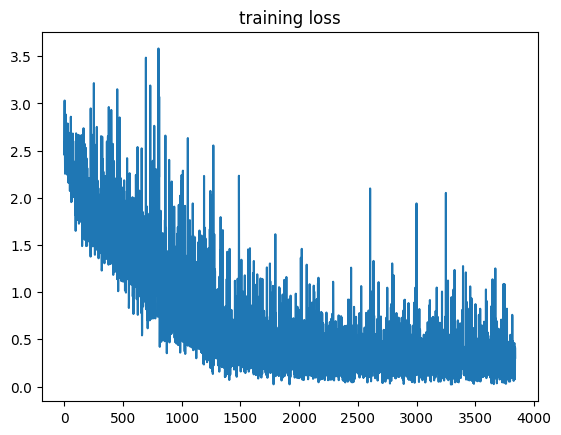

In [81]:
log_interval = 20
n_epoch = 60

pbar_update = 1 / (len(train_loader) + len(valid_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
total_accuracy = 0.0
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        valid(model, epoch)
        scheduler.step()

test(model)
# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

As you can see, the accuracy of the model for test data (the data that model has not seen before) is 88%, which reports a high accuracy.

Let’s look at the last words in the
train set, and see how the model did on it.


In [82]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_dataset[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: طلا. Predicted: طلا.


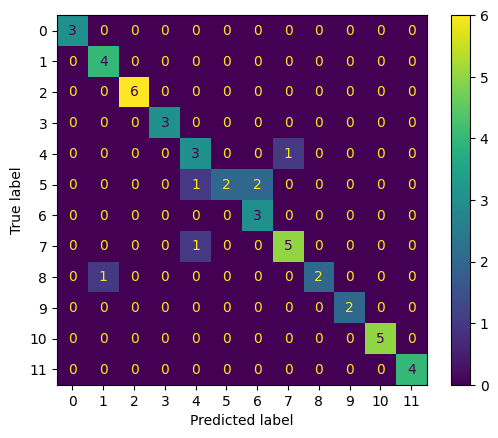

In [83]:
predictions = []
true_labels = []

for data in test_dataset:
  true_labels.append(data[2])
  predictions.append(predict(data[0]))


cm = confusion_matrix(true_labels, predictions)
ConfusionMatrixDisplay(cm).plot()

Now it's time to save the model to .pth file. It is important in this project that our model is less than 10MB.

In [88]:
torch.save(model.state_dict(), 'CNN_model.pth')

# Recognizer class (Just to test the model)

Now it's time to implement a class with some methods to load the trained model, get the input, return the result, and so on. To test the model, you can just run this part of code and get your output :)

In [86]:
class Recognizer():
  def __init__(self, model_path):
    self.model_path = model_path
    self.model = self.load_model()

  def load_model(self):
    model.load_state_dict(torch.load(self.model_path))
    model.eval()

  def predict(self, file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    waveform = waveform.to(device)
    waveform = transform(waveform)
    waveform = model(waveform.unsqueeze(0))
    waveform = get_likely_index(waveform)
    waveform = index_to_label(waveform.squeeze())
    return waveform

file_path = '/content/12words/15/10-(15).mp3'
recognizer = Recognizer('/content/CNN_model.pth')
print('The predicted label is:', recognizer.predict(file_path))

The predicted label is: صندوق درآمد ثابت
